In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import tree
import sklearn.linear_model as LM
from sklearn import ensemble
from sklearn.datasets import make_classification,make_circles,make_regression
from sklearn.metrics import zero_one_loss,r2_score,mean_squared_error

Text(0.5, 1.0, '线性模型和回归树的方差对比')

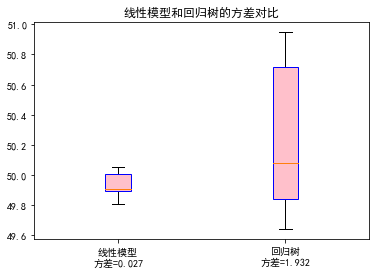

In [2]:
data=pd.read_excel('北京市空气质量数据.xlsx')
data=data.replace(0,np.NaN)
data=data.dropna()
data=data.loc[(data['PM2.5']<=200) & (data['SO2']<=20)]
X=data[['SO2','CO']]
Y=data['PM2.5']
X0=np.array(X.mean()).reshape(1,-1)

modelDTC = tree.DecisionTreeRegressor(max_depth=3,random_state=123)
modelLR=LM.LinearRegression()
model1,model2=[],[]    
kf = KFold(n_splits=10,shuffle=True,random_state=123)
for train_index, test_index in kf.split(X):  
    Ntrain=len(train_index)
    XKtrain=X.iloc[train_index]
    YKtrain=Y.iloc[train_index]      
    modelLR.fit(XKtrain,YKtrain)
    modelDTC.fit(XKtrain,YKtrain)
    model1.append(float(modelLR.predict(X0)))
    model2.append(float(modelDTC.predict(X0)))

plt.boxplot(x=model1,sym='rd',patch_artist=True,boxprops={'color':'blue','facecolor':'pink'},
            labels ={"线性模型\n方差=%.3f"%np.var(model1)},showfliers=False) 
plt.boxplot(x=model2,sym='rd',positions=[2],patch_artist=True,boxprops={'color':'blue','facecolor':'pink'},
            labels ={"回归树\n方差=%.3f"%np.var(model2)},showfliers=False) 
plt.title("线性模型和回归树的方差对比")

说明：这里基于空气质量监测数据，采用二元线性回归模型和树深度等于3的决策树，建立对PM2.5浓度的预测模型，并对比线性模型和回归树的方差。
1、采用10-折交叉验证法，分别构建回归模型和决策树各10个。
2、分别基于回归模型和决策树各10个预测模型，预测输入变量取均值X0时的PM2.5浓度。
3、分别计算回归模型和决策树各10个预测值直方图，并计算方差。结果表明决策树具有高方差的特点。

In [3]:
dtrErr=1-cross_val_score(modelDTC,X,Y,cv=10,scoring='r2')
BagY0=[]
bagErr=[]
rfErr=[]
rfY0=[]
for b in np.arange(10,200):
    Bag=ensemble.BaggingRegressor(base_estimator=modelDTC,n_estimators=b,oob_score=True,random_state=123,bootstrap=True)
    Bag.fit(X,Y)
    bagErr.append(1-Bag.oob_score_)
    BagY0.append(float(Bag.predict(X0)))
    RF=ensemble.RandomForestRegressor(n_estimators=b,oob_score=True,random_state=123,bootstrap=True)
    RF.fit(X,Y)      
    rfErr.append(1-RF.oob_score_)     
    rfY0.append(float(RF.predict(X0)))

说明：这里基于空气质量监测数据，对比单棵回归树和袋装策略下回归树的测试误差。
1、利用cross_val_score计算10-折交叉验证的单棵回归树的测试误差。
2、计算迭代次数在10至200之间时，袋装策略回归树基于OOB的测试误差，以及对X0的预测误差。
3、计算迭代次数在10至200之间时，随机森林基于OOB的测试误差，以及对X0的预测误差。其中，max_features="auto"意味着随机子集的大小等于输入变量的个数。

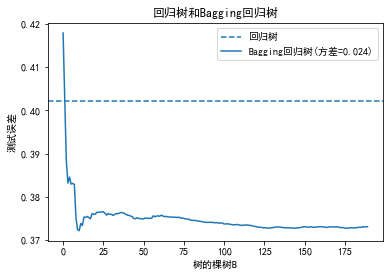

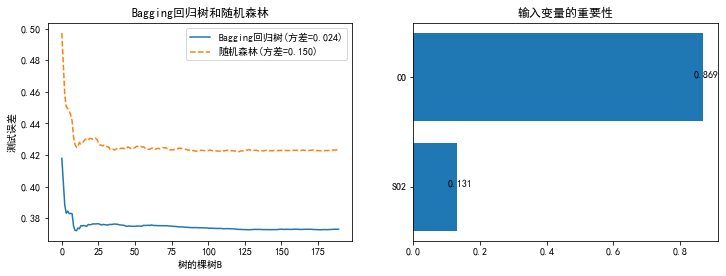

In [4]:
plt.axhline(y=dtrErr.mean(),linestyle='--',label='回归树')
plt.plot(bagErr,linestyle='-',label='Bagging回归树(方差=%.3f)'%np.var(BagY0))
plt.title("回归树和Bagging回归树")
plt.xlabel("树的棵树B")
plt.ylabel("测试误差")
plt.legend()
plt.show()

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].plot(bagErr,linestyle='-',label='Bagging回归树(方差=%.3f)'%np.var(BagY0))
axes[0].plot(rfErr,linestyle='--',label='随机森林(方差=%.3f)'%np.var(rfY0))
axes[0].set_title("Bagging回归树和随机森林")
axes[0].set_xlabel("树的棵树B")
axes[0].set_ylabel("测试误差")
axes[0].legend()
axes[1].barh(y=(1,2),width=RF.feature_importances_,tick_label=X.columns)
axes[1].set_title("输入变量的重要性")
for x,y in enumerate(RF.feature_importances_):    
    axes[1].text(y+0.01,x+1,'%s' %round(y,3),ha='center')


说明：绘制上述计算结果的相关图形。
1、袋装策略回归树和随机森林的测试误差，在迭代次数增加过程中保持了基本一致的变化趋势。袋装策略优于随机森林，与输入变量个数较少有关，并没有充分发挥随机森林对输入变量增加随机性扰动的特点。
2、袋装策略回归树和随机森林的方差均小于单棵回归树。
3、随机森林给出的变量重要性表明CO对预测PM2.5浓度的贡献越大于SO2。

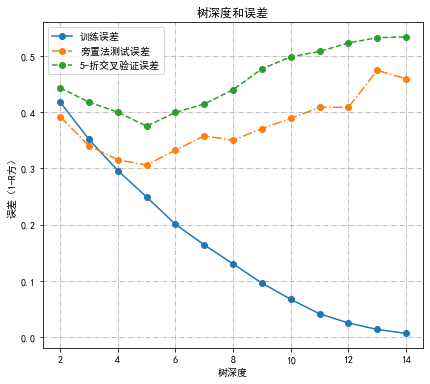

In [5]:
X=data[['SO2','CO','NO2','O3']]
X0=np.array(X.mean()).reshape(1,-1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.70, random_state=123)
trainErr=[]
testErr=[]
CVErr=[]
K=np.arange(2,15)
for k in K:
    modelDTC = tree.DecisionTreeRegressor(max_depth=k,random_state=123)
    modelDTC.fit(X_train,Y_train)
    trainErr.append(1-modelDTC.score(X_train,Y_train))
    testErr.append(1-modelDTC.score(X_test,Y_test))
    Err=1-cross_val_score(modelDTC,X,Y,cv=5,scoring='r2')   
    CVErr.append(Err.mean())    

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121) 
ax1.grid(True, linestyle='-.')
ax1.plot(K,trainErr,label="训练误差",marker='o',linestyle='-')
ax1.plot(K,testErr,label="旁置法测试误差",marker='o',linestyle='-.')
ax1.plot(K,CVErr,label="5-折交叉验证误差",marker='o',linestyle='--')
ax1.set_xlabel("树深度")
ax1.set_ylabel("误差（1-R方）")
ax1.set_title('树深度和误差')
ax1.legend()

说明：
1、为进一步说明袋装策略决策树和随机森林的预测效果优于单棵决策树，首先增加输入变量个数，增加单棵决策树的树深度，计算旁置法和5-折交叉验证的测试误差。
2、依据测试误差最低为原则，确定单棵决策树的树深度等于5。

In [6]:
modelDTC = tree.DecisionTreeRegressor(max_depth=5,random_state=123)
dtrErr=1-cross_val_score(modelDTC,X,Y,cv=10,scoring='r2')
BagY0=[]
bagErr=[]
rfErr=[]
rfY0=[]
for b in np.arange(10,200):
    Bag=ensemble.BaggingRegressor(base_estimator=modelDTC,n_estimators=b,oob_score=True,random_state=123,bootstrap=True)
    Bag.fit(X,Y)
    bagErr.append(1-Bag.oob_score_)
    BagY0.append(float(Bag.predict(X0)))
    RF=ensemble.RandomForestRegressor(n_estimators=b,oob_score=True,random_state=123,bootstrap=True,max_features="sqrt")
    RF.fit(X,Y)      
    rfErr.append(1-RF.oob_score_)     
    rfY0.append(float(RF.predict(X0)))

说明：为对比袋装策略决策树、随机森林、单棵决策树的预测效果，计算迭代次数在10至200之间时，袋装策略回归树和随机森林的基于OOB的测试误差，以及对X0的预测误差。此外，计算单棵决策树的10-折交叉验证测试误差。

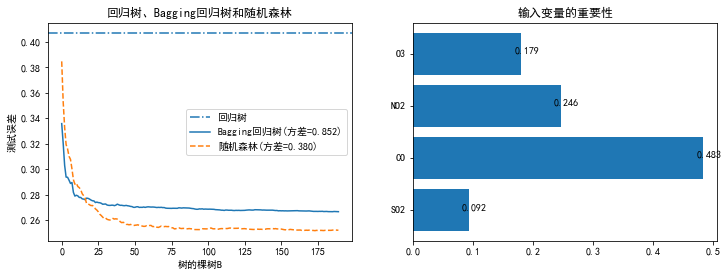

In [7]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].axhline(y=dtrErr.mean(),linestyle='-.',label='回归树')
axes[0].plot(bagErr,linestyle='-',label='Bagging回归树(方差=%.3f)'%np.var(BagY0))
axes[0].plot(rfErr,linestyle='--',label='随机森林(方差=%.3f)'%np.var(rfY0))
axes[0].set_title("回归树、Bagging回归树和随机森林")
axes[0].set_xlabel("树的棵树B")
axes[0].set_ylabel("测试误差")
axes[0].legend()

axes[1].barh(y=(1,2,3,4),width=RF.feature_importances_,tick_label=X.columns)
axes[1].set_title("输入变量的重要性")
for x,y in enumerate(RF.feature_importances_):    
    axes[1].text(y+0.01,x+1,'%s' %round(y,3),ha='center')


说明：绘制上述计算结果的相关图形。可见，增加了输入变量个数后，随机森林的测试误差低于袋装策略下的测试误差。可见，随机森林给输入变量增加的随机性扰动，有效降低了测试误差，发挥了随机森林算法的优势。此外，CO对预测PM2.5浓度有最为重要的影响。